Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3200 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 984s 10s/step - accuracy: 0.1839 - loss: 2.5023 - val_accuracy: 0.5250 - val_loss: 1.4858 - learning_rate: 1.0000e-04
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.5022 - loss: 1.4074 - val_accuracy: 0.6975 - val_loss: 0.9989 - learning_rate: 1.0000e-04
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.6988 - loss: 0.9553 - val_accuracy: 0.7887 - val_loss: 0.7465 - learning_rate: 1.0000e-04
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.8146 - loss: 0.6807 - val_accuracy: 0.8300 - val_loss: 0.6112 - learning_rate: 1.0000e-04
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 297s 3s/step - accuracy: 0.8529 - loss: 0.5479 - val_accuracy: 0.8587 - val_loss: 0.5151 - learning_rate: 1.0000e-04
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.8833 - loss: 0.4433 - val_accuracy: 0.8637 - val_loss: 0.4684 - learning_rate: 1.0000e-04
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - ac

✅ Model saved at: /content/drive/MyDrive/savedModels/mango_disease_model.h5


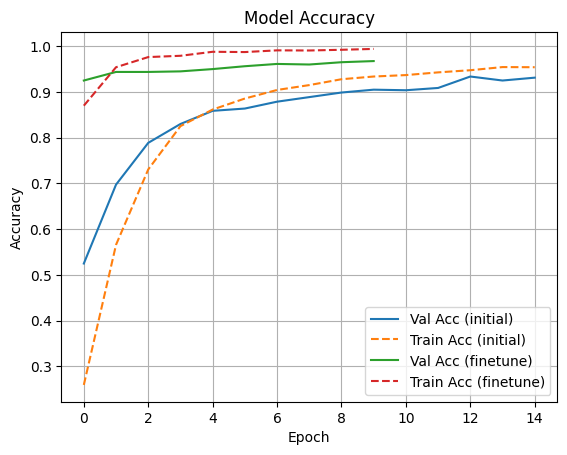

In [2]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Set paths
dataset_path = '/content/drive/MyDrive/PlantDisease/Mango'  # Update if needed
model_save_path = '/content/drive/MyDrive/savedModels/mango_disease_model.h5'

# STEP 3: Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# STEP 4: Data Preparation
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# STEP 5: Load MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base

# STEP 6: Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# STEP 7: Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# STEP 8: Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# STEP 9: Initial Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stop, lr_scheduler]
)

# STEP 10: Fine-tune by unfreezing last 40 layers
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# STEP 11: Fine-tuning
history_finetune = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stop, lr_scheduler]
)

# STEP 12: Save model
model.save(model_save_path)
print("✅ Model saved at:", model_save_path)

# STEP 13: Plot accuracy
def plot_accuracy(histories, labels):
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['val_accuracy'], label=f'Val Acc ({label})')
        plt.plot(hist.history['accuracy'], linestyle='--', label=f'Train Acc ({label})')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy([history, history_finetune], ["initial", "finetune"])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving 20211129_160428 (Custom).jpg to 20211129_160428 (Custom).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🥭 Predicted Disease: Die Back
✅ Confidence: 99.64%
💡 Treatment Suggestion: ✂ Prune infected parts well below the affected area. Apply Bordeaux paste or fungicides.


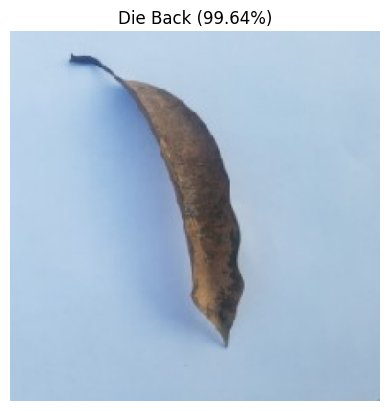

In [4]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Upload a custom image for prediction
from google.colab import files
uploaded = files.upload()

import os
image_path = list(uploaded.keys())[0]  # Name of the uploaded image

# STEP 3: Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# STEP 4: Load the trained mango model
model = load_model('/content/drive/MyDrive/savedModels/mango_disease_model.h5')  # ✅ Update model path if needed

# STEP 5: Preprocess the uploaded image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)  # ✅ Match the model's training preprocessing
img_array = np.expand_dims(img_array, axis=0)

# STEP 6: Predict the disease class
pred = model.predict(img_array)
class_index = np.argmax(pred[0])
confidence = np.max(pred[0]) * 100

# STEP 7: Class labels and treatment suggestions for Mango
class_labels = [
    'Anthracnose',
    'Bacterial Canker',
    'Cutting Weevil',
    'Die Back',
    'Gall Midge',
    'Healthy',
    'Powdery Mildew',
    'Sooty Mould'
]

treatment_suggestions = {
    'Anthracnose': '🧪 Apply copper-based fungicides. Prune affected parts and avoid overhead irrigation.',
    'Bacterial Canker': '🛡 Use bactericides and remove infected branches. Ensure proper airflow and sanitation.',
    'Cutting Weevil': '🐛 Apply recommended insecticides and remove affected twigs manually.',
    'Die Back': '✂ Prune infected parts well below the affected area. Apply Bordeaux paste or fungicides.',
    'Gall Midge': '🦟 Use systemic insecticides. Destroy fallen infested plant parts.',
    'Healthy': '✅ The plant appears healthy. Maintain regular care and monitoring.',
    'Powdery Mildew': '🌫 Spray with sulfur-based fungicides. Ensure proper ventilation.',
    'Sooty Mould': '🧼 Manage sucking pests (e.g., aphids). Wash affected areas and use fungicidal sprays.'
}

# STEP 8: Output the prediction and suggestion
predicted_label = class_labels[class_index]
suggestion = treatment_suggestions[predicted_label]

print(f"🥭 Predicted Disease: {predicted_label}")
print(f"✅ Confidence: {confidence:.2f}%")
print(f"💡 Treatment Suggestion: {suggestion}")

# STEP 9: Display the uploaded image
plt.imshow(img)
plt.axis('off')
plt.title(f"{predicted_label} ({confidence:.2f}%)")
plt.show()
